# Hazard assessment for river flooding using river discharge statistics

This workflow uses the dataset of hydrological climate impact indicators by SMHI that is [available via the Copernicus Data Store](https://doi.org/10.24381/cds.73237ad6).

The following variables are used in this workflow:
- daily timeseries of gridded river discharges in the historical period based on the E-HYPEgrid model.
- monthly means of gridded river discharges over a 30-year period (1971-2000) based on the E-HYPEgrid model.
- monthly means of catchment-level river discharges (in the period 1971-2000) based on the E-HYPEcatch multi-model ensemble.
- extreme river discharges in the historical climate (1971-2000) based on the E-HYPEcatch multi-model ensemble.
- relative change in extreme river discharges in early-, mid- and end-century under climate scenarios based on the E-HYPEcatch multi-model ensemble.

The resolution of the gridded dataset is 5km. The resolution of the catchment-level data is approx. 0.11 degrees (5-10 km).

Relative change in flood recurrence data is available for 2, 5, 10, 50-year return periods and for the following timelines:
- early century (2011-2040)
- mid-century (2041-2070)
- end-century (2071-2100)

For each time period, climate scenarios RCP2.6, RCP4.5 and RCP8.5 are available. 

Relative increases in flood recurrence for these periods are expressed relative to the reference period (1971-2000).

(more information on the dataset and limitations to be added)


## Preparation work

### Select area of interest
First, we will define the coordinates of the area of interest. Based on these coordinates we will be able to clip the dataset for further processing focusing on the specific area.

In [49]:
## name the area for saving datasets and plots# specify the coordinates of the bounding box

# Examples:
#areaname = 'Putna_Romania'
#bbox = [25.34068,47.740031,25.884503,47.964885] 
#loc = [25.61, 47.865]

#areaname = 'Zilina_Slovakia'
#bbox = [18.463238,49.127604,19.007062,49.346389] 
#loc = [18.717, 49.25]

areaname = 'Maastricht_NL'
bbox = [5.4268,50.7288,6.0,51.089]
loc = [5.697, 50.849]

In [50]:
flag_download = False

### Load libraries

`````{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - Provides a way to interact with the operating system, allowing the creation of directories and file manipulation.
- [numpy](https://numpy.org/) - A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
- [xarray](https://docs.xarray.dev/en/stable/) - library for working with labelled multi-dimensional arrays.
- [matplotlib](https://matplotlib.org/) - A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.
- cdsapi
- zipfile
- cartopy
- geopandas

These libraries collectively enable the download, processing, analysis, and visualization of geospatial and numerical data, making them crucial for this risk workflow.
`````

In [ ]:
import os
from glob import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cdsapi
import zipfile
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point

### Create the directory structure
In order for this workflow to work even if you download and use just this notebook, we need to set up the directory structure.  
In the next cell will create the directory called 'FLOOD_RIVER_discharges' in the same directory where this notebook is saved.

In [52]:
# Define the folder for the flood workflow
workflow_folder = 'FLOOD_RIVER_discharges'
os.makedirs(workflow_folder, exist_ok=True)

data_folder = os.path.join(workflow_folder, 'data')
os.makedirs(data_folder, exist_ok=True)

data_folder_gridded = os.path.join(data_folder, 'EHYPEgrid')
os.makedirs(data_folder_gridded, exist_ok=True)

data_folder_catch = os.path.join(data_folder, 'EHYPEcatch')
os.makedirs(data_folder_catch, exist_ok=True)

In [53]:
# Define directory for plots within the previously defined workflow folder
plot_dir = os.path.join(workflow_folder, f'plots_{areaname}')

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

## Exploring historical river discharges 

### Daily river discharge timeseries based on the gridded hydrological dataset

We will download the river discharges data for a historical period. This data is generated using the E-HYPEgrid model.

In [54]:
if flag_download:
    client = cdsapi.Client()

In [55]:
years = list(range(2000, 2005))
gcms = ["ec_earth","hadgem2_es","mpi_esm_lr"]
rcms = ["racmo22e","rca4","csc_remo2009"]
ens_members = ['r12i1p1','r1i1p1','r1i1p1']

In [56]:
if flag_download:
    for ii, rcm in enumerate(rcms):
        gcm = gcms[ii]
        ens_member = ens_members[ii]

        file = os.path.join(data_folder_gridded, 'download.zip')
        dataset = "sis-hydrology-variables-derived-projections"
        request = {
            "product_type": "essential_climate_variables",
            "variable": ["river_discharge"],
            "variable_type": "absolute_values",
            "time_aggregation": "daily",
            "experiment": ["historical"],
            "hydrological_model": ["e_hypegrid"],
            "rcm": rcm, 
            "gcm": gcm,
            "ensemble_member": ens_member,
            "period":  [str(x) for x in years], 
        }
        client.retrieve(dataset, request, file)

        # Unzip the file that was just downloaded, and remove the zip file
        with zipfile.ZipFile(file, 'r') as zObject:
            zObject.extractall(path=data_folder_gridded)
        os.remove(file)

Defining functions we will use to simplify loading the data and plotting.

In [ ]:
def load_datasets(filenames):
    ds = xr.open_mfdataset(filenames)
    ds.lon.load()
    ds.lat.load()
    ds = ds.set_coords(['lon','lat'])
    if 'time' in list(ds.lat.coords):
        ds['lat'] = ds['lat'].isel(time=0)
    if 'time' in list(ds.lon.coords):
        ds['lon'] = ds['lon'].isel(time=0)        
    return ds

def subset_dataset_bbox(ds, bbox):  # Subset dataset to area selection with bounding box
    ds_sel = ds.where((ds.lon > bbox[0]-0.1) & (ds.lon < bbox[2]+0.1) & (ds.lat > bbox[1]-0.1) & (ds.lat < bbox[3]+0.1), drop=True)
    return ds_sel

def find_index_location(ds, loc): # Find indices of the cell closest to location coordinates
    abslat = np.abs(ds.lat-loc[1])
    abslon = np.abs(ds.lon-loc[0])
    c = np.maximum(abslon, abslat)
    ([yloc], [xloc]) = np.where(c == np.min(c))
    return xloc, yloc

In [72]:
def preprocess_add_gcm(ds):
    ds = ds.set_coords(['lon','lat'])
    if 'time' in list(ds.lat.coords):
        ds['lat'] = ds['lat'].isel(time=0)
    if 'time' in list(ds.lon.coords):
        ds['lon'] = ds['lon'].isel(time=0)  
          
    filename = ds.encoding['source'].split("/")[-1].split("\\")[-1]
    ds['models'] = f'{filename.split("_")[3]}_{filename.split("_")[6]}'
    ds = ds.set_coords('models').expand_dims('models')
    return ds

In [ ]:
# Load dataset
files = glob(os.path.join(data_folder_gridded,'rdis_day_E-HYPEgrid-EUR-11_*_historical_*_grid5km_v1.nc'))
ds_dis = xr.open_mfdataset(files, preprocess=preprocess_add_gcm); del files

In [74]:
ds_dis

<xarray.Dataset> Size: 14GB
Dimensions:  (models: 2, time: 1827, y: 950, x: 1000)
Coordinates:
  * time     (time) datetime64[ns] 15kB 2000-01-01 2000-01-02 ... 2004-12-31
    lat      (y, x) float32 4MB dask.array<chunksize=(950, 1000), meta=np.ndarray>
    lon      (y, x) float32 4MB dask.array<chunksize=(950, 1000), meta=np.ndarray>
  * models   (models) <U29 232B 'MOHC-HadGEM2-ES_KNMI-RACMO22E' 'MPI-M-MPI-ES...
Dimensions without coordinates: y, x
Data variables:
    rdis     (models, time, y, x) float32 14GB dask.array<chunksize=(1, 1, 950, 1000), meta=np.ndarray>
Attributes: (12/26)
    CDI:                      Climate Data Interface version 1.9.8 (https://m...
    NCO:                      "4.6.3"
    CDO:                      Climate Data Operators version 1.9.8 (https://m...
    Conventions:              CF-1.6
    variable_name:            rdis
    invar_gcm_model_id:       MOHC-HadGEM2-ES
    ...                       ...
    history:                  E-HYPEgrid output
    title:                    River discharge
    summary:                  Calculated as  daily simulated outflow from a s...
    keywords:                 river flow, flux
    time_period:              2000
    contact:                  copernicus-support@ecmwf.int

In [76]:
ds_dis.lon.load()
ds_dis.lat.load()
ds_dis_sel = subset_dataset_bbox(ds_dis, bbox)

In [80]:
# Find indices of the grid cell closest to the location of interest
xloc, yloc = find_index_location(ds_dis, loc)
ds_dis_loc = ds_dis.sel(x=xloc, y=yloc)
ds_dis_loc.load()

<xarray.Dataset> Size: 29kB
Dimensions:  (models: 2, time: 1827)
Coordinates:
  * time     (time) datetime64[ns] 15kB 2000-01-01 2000-01-02 ... 2004-12-31
    lat      float32 4B 50.86
    lon      float32 4B 5.686
  * models   (models) <U29 232B 'MOHC-HadGEM2-ES_KNMI-RACMO22E' 'MPI-M-MPI-ES...
Data variables:
    rdis     (models, time) float32 15kB 845.4 826.0 783.8 ... 489.4 472.2 452.1
Attributes: (12/26)
    CDI:                      Climate Data Interface version 1.9.8 (https://m...
    NCO:                      "4.6.3"
    CDO:                      Climate Data Operators version 1.9.8 (https://m...
    Conventions:              CF-1.6
    variable_name:            rdis
    invar_gcm_model_id:       MOHC-HadGEM2-ES
    ...                       ...
    history:                  E-HYPEgrid output
    title:                    River discharge
    summary:                  Calculated as  daily simulated outflow from a s...
    keywords:                 river flow, flux
    time_period:              2000
    contact:                  copernicus-support@ecmwf.int

The plot below illustrates the resolution of the gridded dataset and allows us to check the river discharge timeseries based on two different GCM-RCM combinations. The range and seasonal/monthly pattern of these timeseries allows us to understand better the applicability of the dataset to the specific region, by comparing it to known historical river discharges. 

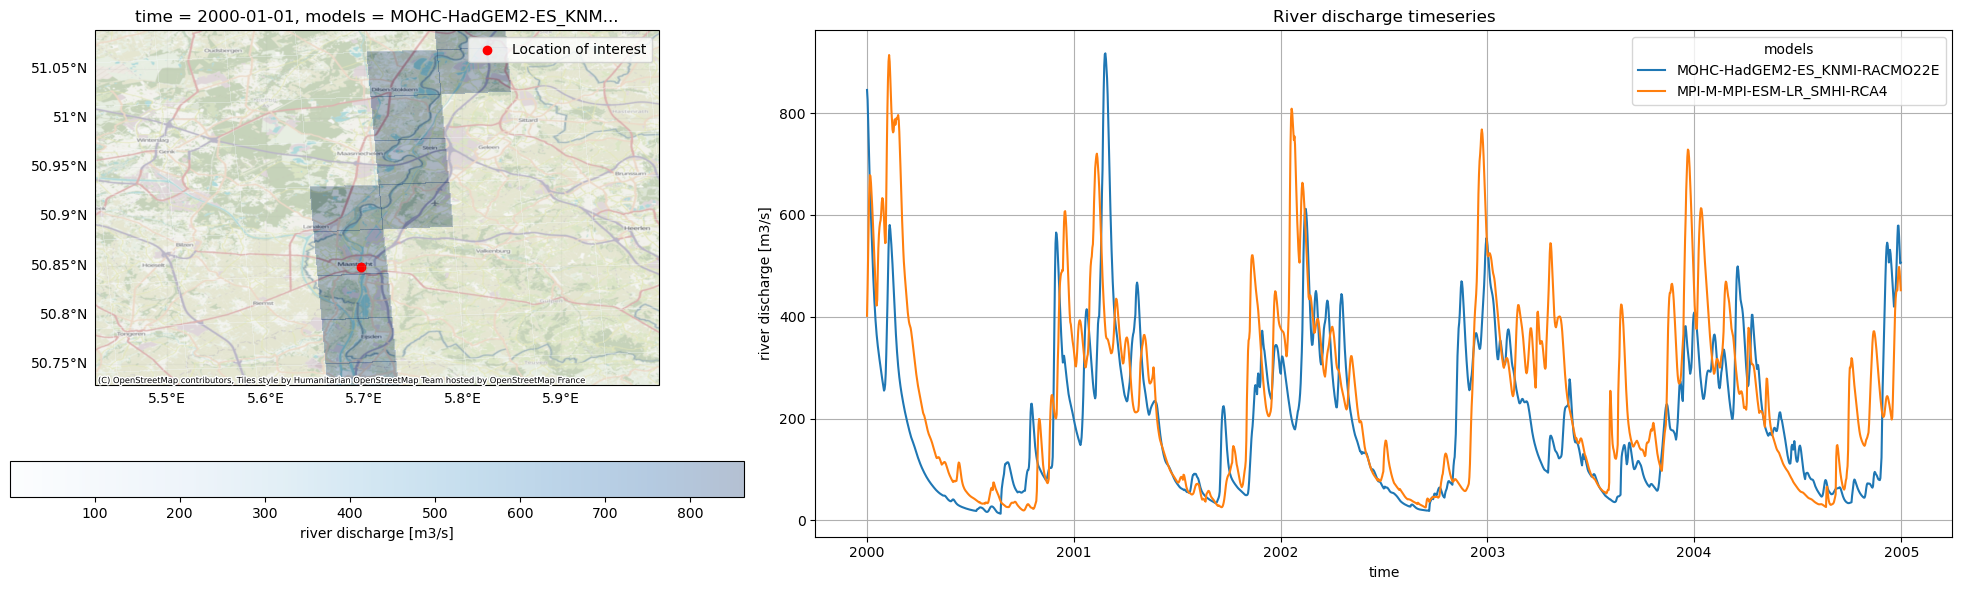

In [87]:
fig = plt.figure(figsize=(20, 6))
ax0 = plt.subplot2grid((1, 5), (0, 0), colspan=2, projection=ccrs.PlateCarree())
ax1 = plt.subplot2grid((1, 5), (0, 2), colspan=3)

# plot data on the map
ax0.set_ylim([bbox[1], bbox[3]])
ax0.set_xlim([bbox[0], bbox[2]])
gl = ax0.gridlines(draw_labels=True, alpha=0.1)
gl.top_labels = gl.right_labels = False

ds_dis_sel.rdis.isel(time=0, models=0).plot(ax=ax0, x="lon", y="lat", transform=ccrs.PlateCarree(), alpha=0.3, cmap='Blues', cbar_kwargs={'location':'bottom'})

ctx.add_basemap(ax=ax0,crs='EPSG:4326', attribution_size=6)

ax0.scatter(loc[0], loc[1], color='red', label='Location of interest')
ax0.legend()

# Plot discharge timeseries
ds_dis_loc.rdis.plot.line(x='time', hue='models')
ax1.grid()
ax1.title.set_text('River discharge timeseries')

fig.tight_layout()

### Historical river discharge statistics based on gridded data

Downloading monthly means of river discharges from gridded dataset for the historical period (1971-2000).

In [88]:
if flag_download:
    for ii, rcm in enumerate(rcms):
        gcm = gcms[ii]
        ens_member = ens_members[ii]
        
        file = os.path.join(data_folder_gridded, 'download.zip')
        dataset = "sis-hydrology-variables-derived-projections"
        request = {
            "product_type": "climate_impact_indicators",
            "variable": ["river_discharge"],
            "variable_type": "absolute_values",
            "time_aggregation": "monthly_mean",
            "experiment": ["historical"],
            "hydrological_model": ["e_hypegrid"],
            "rcm": rcm,
            "gcm": gcm,
            "ensemble_member": ens_member,
            "period": ["1971_2000"]
        }
        client.retrieve(dataset, request, file)

        # Unzip the file that was just downloaded, and remove the zip file
        with zipfile.ZipFile(file, 'r') as zObject:
            zObject.extractall(path=data_folder_gridded)
        os.remove(file)

In order to load all mean discharge datasets in one variable we will use a preprocess function to add GCM and RCM names as a variable. These model names are derived directly from the filename.

In [89]:
def preprocess_add_gcm_stats(ds):
    ds = ds.set_coords(['lon','lat'])
    filename = ds.encoding['source'].split("/")[-1].split("\\")[-1]
    ds['models'] = f'{filename.split("_")[4]}_{filename.split("_")[7]}'
    ds = ds.set_coords('models').expand_dims('models')
    return ds

Opening monthly river discharge statistics from 3 different gcm-rcm combinations.

Check: is the loaded dataset containing all the selected models and 12 months at the time axis?

In [91]:
files = glob(os.path.join(data_folder_gridded, 'rdis_ymonmean_abs_E-HYPEgrid-EUR-11_*_historical_r1i1p1_*_na_1971-2000_grid5km_v1.nc'))
ds_dis_stats = xr.open_mfdataset(files, preprocess=preprocess_add_gcm_stats)
ds_dis_stats.load()

<xarray.Dataset> Size: 144MB
Dimensions:        (models: 3, time: 12, y: 950, x: 1000)
Coordinates:
    lat            (y, x) float32 4MB 27.8 27.81 27.82 ... 58.32 58.28 58.25
    lon            (y, x) float32 4MB -8.229 -8.18 -8.131 ... 73.83 73.88 73.94
  * time           (time) datetime64[ns] 96B 2000-01-01 ... 2000-12-01
  * models         (models) <U36 432B 'MOHC-HadGEM2-ES_KNMI-RACMO22E-v2' ... ...
Dimensions without coordinates: y, x
Data variables:
    rdis_ymonmean  (models, time, y, x) float32 137MB nan nan nan ... nan nan
Attributes: (12/27)
    CDI:                      Climate Data Interface version 1.9.8 (https://m...
    NCO:                      "4.6.3"
    CDO:                      Climate Data Operators version 1.9.8 (https://m...
    source:                   A set of EURO-CORDEX EUR-11 RCM was bias adjust...
    institution:              SMHI, www.smhi.se
    Conventions:              CF-1.6
    ...                       ...
    title:                    Mean monthly river discharge
    summary:                  Calculated as the monthly mean values of daily ...
    keywords:                 river flow, flux
    variable_name:            rdis_ymonmean
    history:                  CDO commands (last cdo command first and separa...
    contact:                  copernicus-support@ecmwf.int

In [92]:
# Subset the dataset to the area of interest and find location indices
ds_dis_stats_sel = subset_dataset_bbox(ds_dis_stats, bbox)
xloc, yloc = find_index_location(ds_dis_stats, loc)

The plot below shows the monthly means of river discharge in the historical period (1971-2000) across the three GCM-RCM combinations.

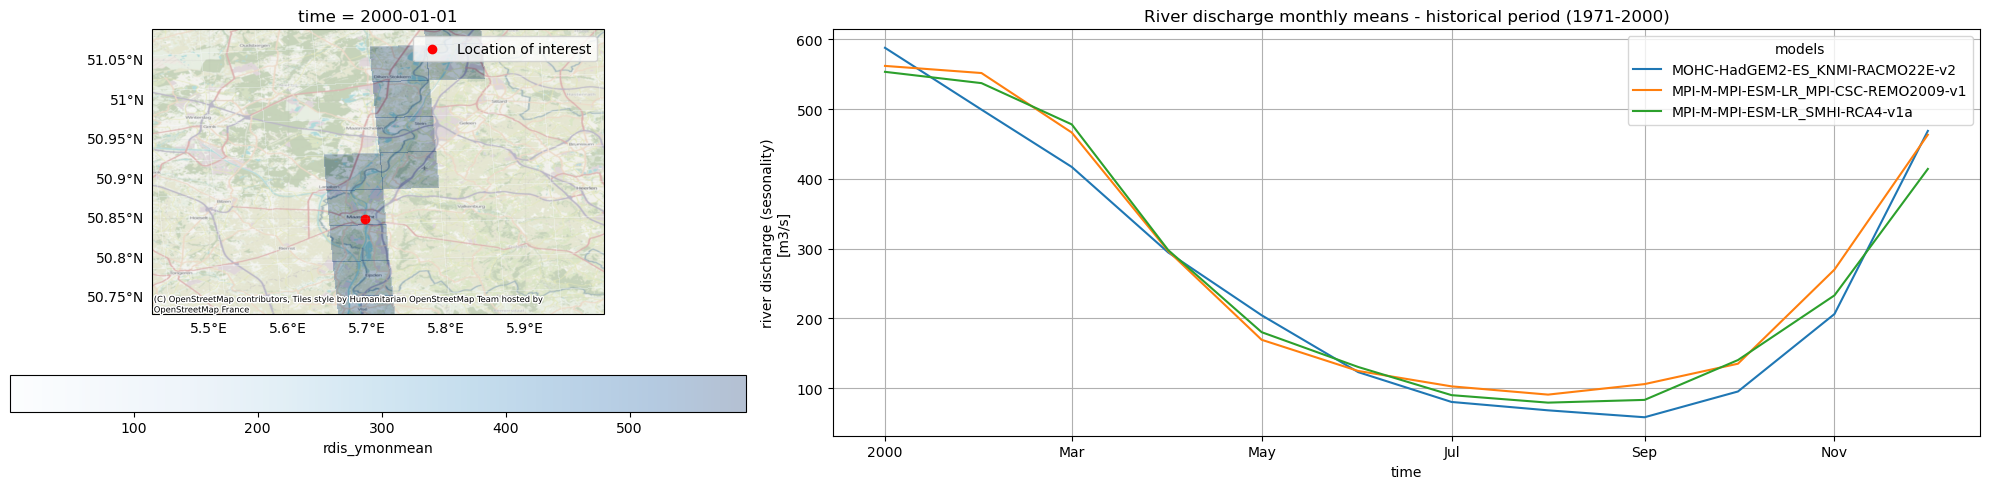

In [95]:
fig = plt.figure(figsize=(20, 5))
ax0 = plt.subplot2grid((1, 5), (0, 0), colspan=2, projection=ccrs.PlateCarree())
ax1 = plt.subplot2grid((1, 5), (0, 2), colspan=3)

# plot data on the map
ax0.set_ylim([bbox[1], bbox[3]])
ax0.set_xlim([bbox[0], bbox[2]])
gl = ax0.gridlines(draw_labels=True, alpha=0.1)
gl.top_labels = gl.right_labels = False

ds_dis_stats_sel.rdis_ymonmean.isel(time=0).mean(dim='models').plot(ax=ax0, x="lon", y="lat", transform=ccrs.PlateCarree(), alpha=0.3, cmap='Blues', cbar_kwargs={'location':'bottom'})
ctx.add_basemap(ax=ax0,crs='EPSG:4326', attribution_size=6)
ax0.scatter(loc[0], loc[1], color='red', label='Location of interest')
ax0.legend()

# Plot discharge monthly means
ds_dis_stats.sel(x=xloc, y=yloc)['rdis_ymonmean'].plot.line(hue='models')
ax1.grid()
ax1.title.set_text('River discharge monthly means - historical period (1971-2000)')

fig.tight_layout()

### Historical river discharge statistics based on catchment-level data

Catchment-level data is stored in a NetCDF file where a specific catchment can be selected by catchment ID. In order to know the ID of the catchment we are interested in, we need to consult the map of catchments (sub-basins) [available in shp format on Zenodo](https://doi.org/10.5281/zenodo.581451). Please download the dataset of subbasins from Zenodo and unzip it in the folder specied below as `data_folder_subbasins`.

Reference to the dataset of subbasin contours:  
Isberg, K. (2017). EHYPE3_subbasins.zip [Data set]. Zenodo. https://doi.org/10.5281/zenodo.581451

In [96]:
data_folder_subbasins = os.path.join(data_folder, 'EHYPE3_subbasins')

In [97]:
# Open dataset with subbasin contours
try:
    catchments = gpd.GeoDataFrame.from_file(os.path.join(data_folder_subbasins, 'EHYPE3_subbasins.shp'))
    print("Dataset loaded.")
except:
    print(f"Dataset with subbasin contours not found. Please download it and place it in the folder {data_folder_subbasins}")

Dataset loaded.


The dataset of subbasin contours was loaded as a GeoDataFrame, we can check its contents:

In [98]:
catchments

,SUBID,HAROID,geometry
0,8801544.0,8801544.0,"MULTIPOLYGON (((-22.9068 65.75671, -22.92437 6..."
1,8801548.0,8801548.0,"POLYGON ((-24.42223 65.55144, -24.39406 65.537..."
2,8000005.0,8000006.0,"MULTIPOLYGON (((9.3944 59.15315, 9.41203 59.14..."
3,8115258.0,8000006.0,"POLYGON ((8.5962 59.30061, 8.59918 59.29174, 8..."
4,8115717.0,8000006.0,"POLYGON ((9.27409 59.01988, 9.27962 59.00213, ..."
...,...,...,...
35403,9566395.0,9566395.0,"POLYGON ((0.15417 49.37083, 0.15417 49.3625, 0..."
35404,9581818.0,9581818.0,"MULTIPOLYGON (((-4.89583 55.7375, -4.87917 55...."
35405,9524166.0,9524166.0,"MULTIPOLYGON (((-1.12917 45.34583, -1.12083 45..."
35406,9581815.0,9581815.0,"MULTIPOLYGON (((-4.89583 56.15417, -4.89583 56..."


Now we need to identify the id of the catchment where the point of interest is located:

In [99]:
point = Point((loc[0],loc[1]))

in_catchment = catchments.geometry.contains(point)

catch_id = int(catchments.iloc[in_catchment.index[in_catchment==True]].SUBID.values.tolist()[0])
print(f'Catchment ID in the E-HYPEcatch dataset: {catch_id}')

Catchment ID in the E-HYPEcatch dataset: 9503381


In [100]:
catchment = catchments[catchments.SUBID==catch_id]
catchment

,SUBID,HAROID,geometry
26859,9503381.0,9507523.0,"POLYGON ((5.67917 50.92083, 5.67917 50.9125, 5..."


Text(0.5, 1.0, 'Catchment contours from E-HYPEcatch corresponding to the location of interest')

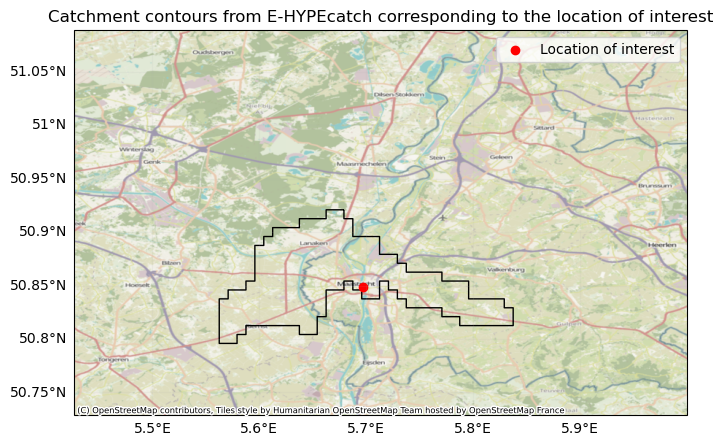

In [101]:
# Plot the catchment on a ctx map
fig = plt.figure(figsize=(10, 5))
ax0 = plt.subplot2grid((1, 1), (0, 0), colspan=2, projection=ccrs.PlateCarree())

# plot data on the map
ax0.set_ylim([bbox[1], bbox[3]])
ax0.set_xlim([bbox[0], bbox[2]])
gl = ax0.gridlines(draw_labels=True, alpha=0.1)
gl.top_labels = gl.right_labels = False

catchment.geometry.plot(ax=ax0, facecolor='None')

ax0.scatter(loc[0], loc[1], color='red', label='Location of interest')
ax0.legend()

ctx.add_basemap(ax=ax0,crs='EPSG:4326', attribution_size=6)

ax0.set_title('Catchment contours from E-HYPEcatch corresponding to the location of interest')

Downloading catchment-level discharge data for historical period. Data is available based on different E-HYPEcatch model realizations. We will download all model realizations.

In [102]:
if flag_download:
    for ii, rcm in enumerate(rcms):
        gcm = gcms[ii]
        ens_member = ens_members[ii]
        file = os.path.join(data_folder_catch, 'download.zip')
        dataset = "sis-hydrology-variables-derived-projections"
        request = {
            "product_type": "climate_impact_indicators",
            "variable": ["river_discharge"],
            "variable_type": "absolute_values",
            "time_aggregation": "monthly_mean",
            "experiment": ["historical"],
            "hydrological_model":   ["e_hypecatch_m00",
                                    "e_hypecatch_m01",
                                    "e_hypecatch_m02",
                                    "e_hypecatch_m03",
                                    "e_hypecatch_m04",
                                    "e_hypecatch_m05",
                                    "e_hypecatch_m06",
                                    "e_hypecatch_m07"],
            "rcm": rcm,
            "gcm": gcm,
            "ensemble_member": ens_member,
            "period": ["1971_2000"]
        }
        client.retrieve(dataset, request, file)

        # Unzip the file that was just downloaded, and remove the zip file
        with zipfile.ZipFile(file, 'r') as zObject:
            zObject.extractall(path=data_folder_catch)
        os.remove(file)


Downloading catchment-level discharge data for future periods. Data is available based on different E-HYPEcatch model realizations. 

In [ ]:
if flag_download:
    for ii, rcm in enumerate(rcms):
        gcm = gcms[ii]
        ens_member = ens_members[ii]

        for period in ["2011_2040","2041_2070","2071_2100"]:
            file = os.path.join(data_folder_catch, 'download.zip')
            dataset = "sis-hydrology-variables-derived-projections"
            request = {
                "product_type": "climate_impact_indicators",
                "variable": ["river_discharge"],
                "variable_type": "absolute_values",
                "time_aggregation": "monthly_mean",
                "experiment": ["rcp_4_5","rcp_8_5"],
                "hydrological_model":  ["e_hypecatch_m00",
                                        "e_hypecatch_m01",
                                        "e_hypecatch_m02",
                                        "e_hypecatch_m03",
                                        "e_hypecatch_m04",
                                        "e_hypecatch_m05",
                                        "e_hypecatch_m06",
                                        "e_hypecatch_m07"],
                "rcm": rcm,
                "gcm": gcm,
                "ensemble_member": ens_member,
                "period": period
            }
            client.retrieve(dataset, request, file)

            # Unzip the file that was just downloaded, and remove the zip file
            with zipfile.ZipFile(file, 'r') as zObject:
                zObject.extractall(path=data_folder_catch)
            os.remove(file)

Preprocess function to inclide model names and model configuraton in the dataset dimensions:

In [129]:
def preprocess_add_gcm_catch(ds):
    filename = ds.encoding['source'].split("/")[-1].split("\\")[-1]
    ds['gcm_rcm'] = f'{filename.split("_")[4]}_{filename.split("_")[7]}'
    ds = ds.set_coords('gcm_rcm').expand_dims('gcm_rcm')

    ds['catchmodel'] = filename.split("_")[3]
    ds = ds.set_coords('catchmodel').expand_dims('catchmodel')    

    ds['scenarios'] = filename.split("_")[5]
    ds = ds.set_coords('scenarios').expand_dims('scenarios')

    ds['time_period'] = filename.split("_")[9]
    ds = ds.set_coords('time_period').expand_dims('time_period')

    ds['time'] = ds.time.dt.month

    return ds

Open catchment-level river discharge data for the historical period:

In [130]:
files = glob(os.path.join(data_folder_catch, 'rdis_ymonmean_abs_E-HYPEcatch*-EUR-11_*_na_*_catch_v1.nc'))
ds_cat = xr.open_mfdataset(files, preprocess=preprocess_add_gcm_catch)

c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{F1855C36-0FD3-4197-A97E-4AB8346F3786}\SVROOT\Users\aleksand\AppData\Local\miniforge3\envs\climaax_floods\Lib\site-packages\dask\array\core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{F1855C36-0FD3-4197-A97E-4AB8346F3786}\SVROOT\Users\aleksand\AppData\Local\miniforge3\envs\climaax_floods\Lib\site-packages\dask\array\core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(


In [131]:
ds_cat

<xarray.Dataset> Size: 642MB
Dimensions:        (time_period: 4, scenarios: 3, catchmodel: 8, gcm_rcm: 4,
                    time: 12, id: 34810)
Coordinates:
  * time           (time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * id             (id) int32 139kB 8801654 8000123 8212459 ... 9605711 9601936
  * catchmodel     (catchmodel) <U20 640B 'E-HYPEcatch00-EUR-11' ... 'E-HYPEc...
  * scenarios      (scenarios) <U10 120B 'historical' 'rcp45' 'rcp85'
  * time_period    (time_period) <U9 144B '1971-2000' ... '2071-2100'
  * gcm_rcm        (gcm_rcm) <U36 576B 'ICHEC-EC-EARTH_KNMI-RACMO22E-v1' ... ...
Data variables:
    rdis_ymonmean  (time_period, scenarios, catchmodel, gcm_rcm, time, id) float32 642MB dask.array<chunksize=(2, 2, 1, 1, 1, 34810), meta=np.ndarray>
Attributes: (12/28)
    CDI:                      Climate Data Interface version 1.9.5 (http://mp...
    Conventions:              CF-1.6
    NCO:                      netCDF Operators version 4.7.7 (Homepage = http...
    comment:                  -
    CDO:                      Climate Data Operators version 1.9.5 (http://mp...
    history:                  CDO commands (last cdo command first and separa...
    ...                       ...
    invar_hm_model_id:        Hydrological models in the order of the variabl...
    invar_experiment_name:    rcp45
    time_coverage_start:      20110101
    time_coverage_end:        20401231
    variable_name:            rdis_ymonmean
    contact:                  copernicus-support@ecmwf.int

Select only the data for the specific catchment:

In [132]:
ds_cat_sel = ds_cat.sel(id=catch_id)

Check variation in results due to different catchment models in the E-HYPEcatch multi-model ensemble for historical period:

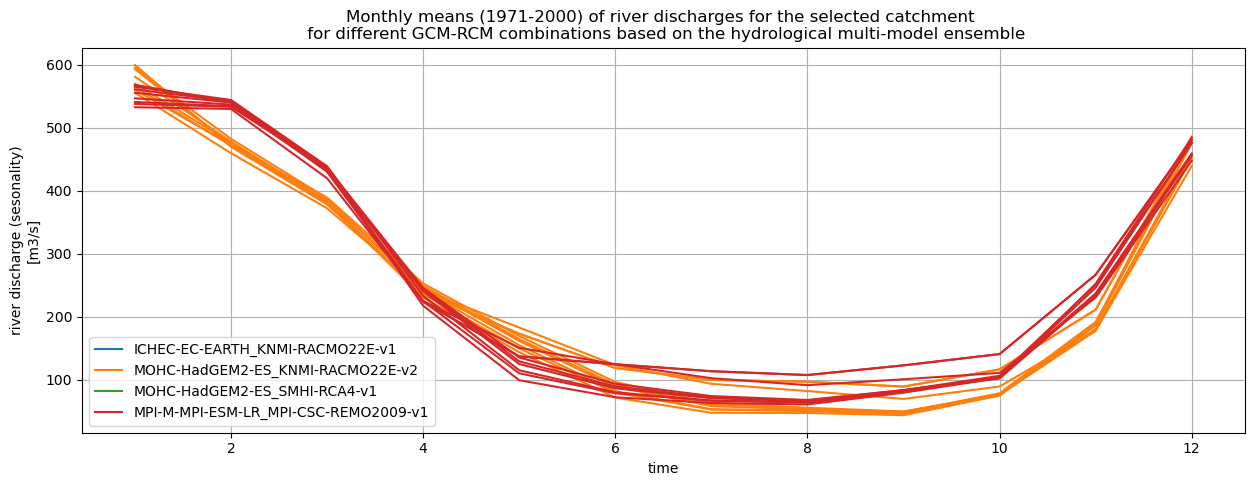

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

colors = mcolors.TABLEAU_COLORS
colorlist = list(colors.keys())

for ii, model in enumerate(ds_cat_sel['gcm_rcm'].values):
    ds_cat_sel['rdis_ymonmean'].sel(time_period='1971-2000', scenarios='historical').isel(gcm_rcm=ii, catchmodel=0).plot.line(ax=ax, x='time', color=colorlist[ii], label=model)
    ds_cat_sel['rdis_ymonmean'].sel(time_period='1971-2000', scenarios='historical').isel(gcm_rcm=ii).plot.line(ax=ax, x='time', color=colorlist[ii]) 

ax.grid()
ax.legend()
ax.set_title('Monthly means (1971-2000) of river discharges for the selected catchment \n for different GCM-RCM combinations based on the hydrological multi-model ensemble');

**Reflect on the plot above:** is there a lot of variation in river discharges across the E-HYPEcatch model ensemble when looking at one specific GCM-RCM model combination? In the example above the variation is limited.
We can now plot river discharges averaged across the hydrological multi-model ensemble:

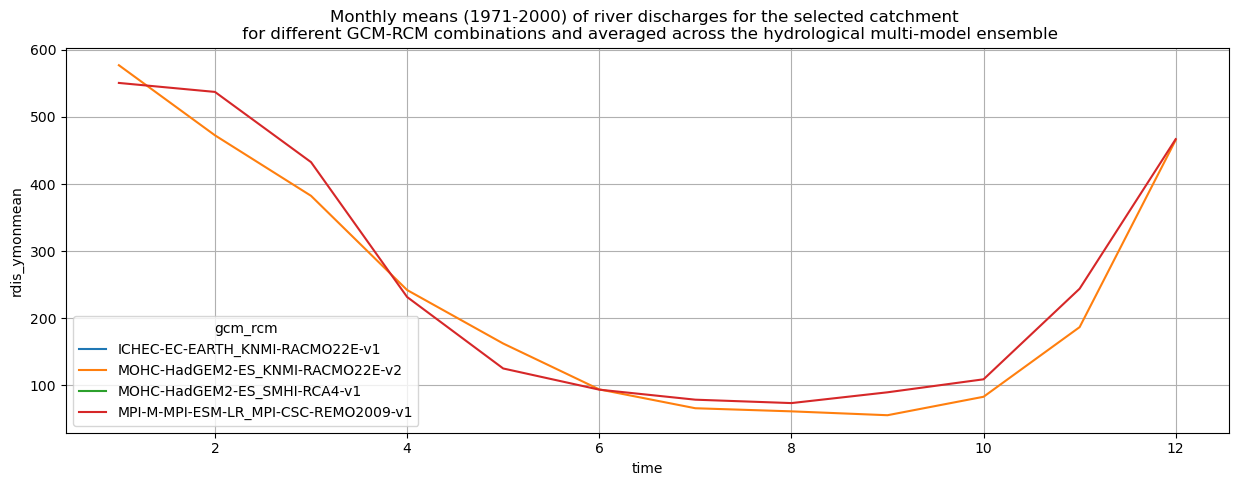

In [152]:
fig, ax = plt.subplots(figsize=(15,5))
ds_cat_sel['rdis_ymonmean'].sel(time_period='1971-2000', scenarios='historical').mean(dim='catchmodel').plot.line(ax=ax, x='time')
ax.grid() 
ax.set_title('Monthly means (1971-2000) of river discharges for the selected catchment \n for different GCM-RCM combinations and averaged across the hydrological multi-model ensemble');

**Reflect on the plot above:** do the river discharges for this catchment correspond to the local experience of this specific area both in seasonal pattern and magnitude? If there are significant differences then it may be concluded that the model is less suitable for the river flood hazard assessment in this specific area, e.g. due to low resolution or due to some relevant processes not being included (i.e. water management infrastructure such as dams).

### Future river discharge statistics based on catchment-level data

In [154]:
ds_cat_sel['rdis_ymonmean'].mean(dim='catchmodel').mean(dim='gcm_rcm')

<xarray.DataArray 'rdis_ymonmean' (time_period: 4, scenarios: 3, time: 12)> Size: 576B
dask.array<mean_agg-aggregate, shape=(4, 3, 12), dtype=float32, chunksize=(2, 2, 1), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    id           int32 4B 9503381
  * scenarios    (scenarios) <U10 120B 'historical' 'rcp45' 'rcp85'
  * time_period  (time_period) <U9 144B '1971-2000' '2011-2040' ... '2071-2100'

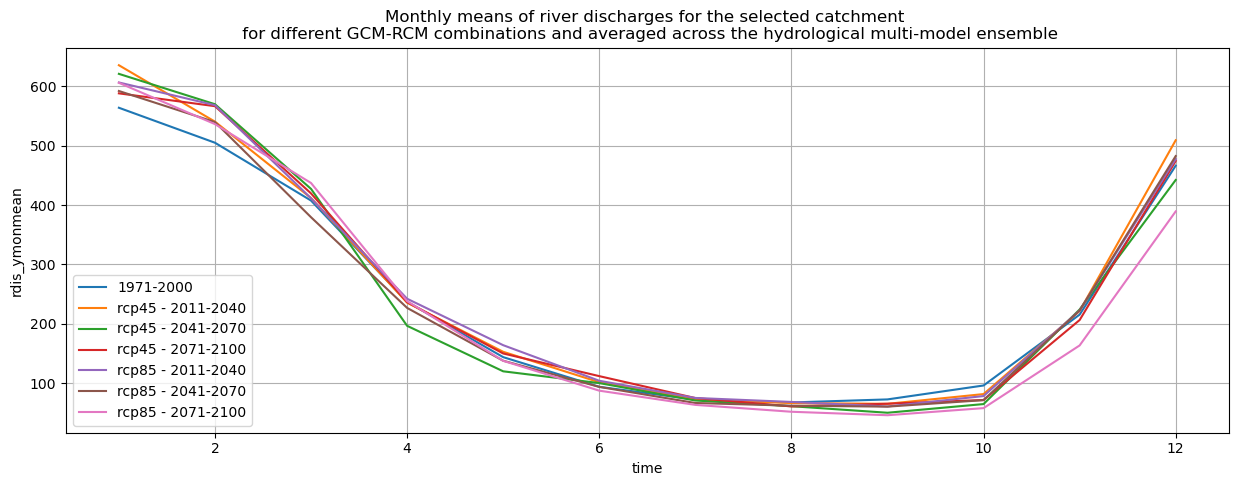

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
ds_cat_sel['rdis_ymonmean'].sel(time_period='1971-2000', scenarios='historical').mean(dim='catchmodel').mean(dim='gcm_rcm').plot.line(ax=ax, x='time', label='1971-2000', color='k')

for timep in ['2011-2040', '2041-2070', '2071-2100']:
    for scen in ['rcp45', 'rcp85']:
        ds_cat_sel['rdis_ymonmean'].mean(dim='catchmodel').mean(dim='gcm_rcm').sel(scenarios=scen, time_period=timep).plot.line(ax=ax, x='time', label=f'{scen} - {timep}')
ax.grid() 
ax.legend()
ax.set_title('Monthly means of river discharges for the selected catchment \n for different GCM-RCM combinations and averaged across the hydrological multi-model ensemble');

## Flood occurence in historical and future climates

Based on catchment-level dataset (E-HYPEcatch).

Download flood occurence for different RPs, climate scenarios, timelines, catchment models

Downloading 50 yr return period flood recurrence for the historical climate:

In [160]:
if flag_download:
    for ii, rcm in enumerate(rcms):
        gcm = gcms[ii]
        ens_member = ens_members[ii]
        
        for period in ["2011_2040","2041_2070","2071_2100"]:
            file = os.path.join(data_folder_catch, 'download.zip')
            dataset = "sis-hydrology-variables-derived-projections"
            request = {
                "product_type": "climate_impact_indicators",
                "variable": ["flood_recurrence_50_years_return_period"],
                "variable_type": "absolute_values",
                "time_aggregation": "annual_mean",
                "experiment": ["historical"],
                "hydrological_model": ["e_hypecatch_m00",
                                        "e_hypecatch_m01",
                                        "e_hypecatch_m02",
                                        "e_hypecatch_m03",
                                        "e_hypecatch_m04",
                                        "e_hypecatch_m05",
                                        "e_hypecatch_m06",
                                        "e_hypecatch_m07"],
                "rcm": rcm,
                "gcm": gcm,
                "ensemble_member": ens_member,
                "period": period
            }   
            client.retrieve(dataset, request, file)

            # Unzip the file that was just downloaded, and remove the zip file
            with zipfile.ZipFile(file, 'r') as zObject:
                zObject.extractall(path=data_folder_catch)
            os.remove(file)


Downloading 50 yr return period flood recurrence for the climate scenarios:

In [161]:
if flag_download:
    for ii, rcm in enumerate(rcms):
        gcm = gcms[ii]
        ens_member = ens_members[ii]

        for period in ["2011_2040","2041_2070","2071_2100"]:
            file = os.path.join(data_folder_catch, 'download.zip')
            dataset = "sis-hydrology-variables-derived-projections"
            request = {
                "product_type": "climate_impact_indicators",
                "variable": ["flood_recurrence_50_years_return_period"],
                "variable_type": "absolute_values",
                "time_aggregation": "annual_mean",
                "experiment": ["rcp_4_5","rcp_8_5"],
                "hydrological_model":  ["e_hypecatch_m00",
                                        "e_hypecatch_m01",
                                        "e_hypecatch_m02",
                                        "e_hypecatch_m03",
                                        "e_hypecatch_m04",
                                        "e_hypecatch_m05",
                                        "e_hypecatch_m06",
                                        "e_hypecatch_m07"],
                "rcm": rcm,
                "gcm": gcm,
                "ensemble_member": ens_member,
                "period": period
            }   
            client.retrieve(dataset, request, file)

            # Unzip the file that was just downloaded, and remove the zip file
            with zipfile.ZipFile(file, 'r') as zObject:
                zObject.extractall(path=data_folder_catch)
            os.remove(file)


We will make use of a preprocessing function to write model names and scenarios to the dataset dimensions:

In [ ]:
def preprocess_add_gcm_scenarios(ds):
    filename = ds.encoding['source'].split("/")[-1].split("\\")[-1]
    ds['gcm_rcm'] = f'{filename.split("_")[4]}_{filename.split("_")[7]}'
    ds = ds.set_coords('gcm_rcm').expand_dims('gcm_rcm')

    ds['scenarios'] = filename.split("_")[5]
    ds = ds.set_coords('scenarios').expand_dims('scenarios')

    time_period = [filename.split("_")[9]]
    ds = ds.assign_coords(time_period=("time",time_period))
    return ds

In [163]:
files = glob(os.path.join(data_folder_catch, 'rdisreturnmax50_tmean_abs_E-HYPEcatch*_catch_v1.nc'))
ds_flood = xr.open_mfdataset(files, preprocess=preprocess_add_gcm_scenarios)

In [164]:
# Subset to catchment of interest
ds_flood_sel = ds_flood.sel(id=catch_id)

In [165]:
ds_flood_sel

<xarray.Dataset> Size: 1kB
Dimensions:                (scenarios: 3, models: 5, time: 4)
Coordinates:
    id                     int32 4B 9503381
  * time                   (time) datetime64[ns] 32B 1971-01-01 ... 2071-01-01
  * scenarios              (scenarios) <U10 120B 'historical' 'rcp45' 'rcp85'
  * models                 (models) <U36 720B 'ICHEC-EC-EARTH_KNMI-RACMO22E-v...
    time_period            (time) object 32B '1971-2000' ... '2071-2100'
Data variables:
    rdisreturnmax50_tmean  (scenarios, models, time) float32 240B dask.array<chunksize=(2, 1, 2), meta=np.ndarray>
Attributes: (12/29)
    CDI:                      Climate Data Interface version 1.8.2 (http://mp...
    Conventions:              CF-1.6
    NCO:                      netCDF Operators version 4.7.7 (Homepage = http...
    frequency:                year
    CDO:                      Climate Data Operators version 1.8.2 (http://mp...
    comment:                  -
    ...                       ...
    invar_hm_model_id:        Hydrological models in the order of the variabl...
    invar_experiment_name:    rcp45
    time_coverage_start:      20110101
    time_coverage_end:        20401231
    variable_name:            rdisreturnmax50_tmean
    contact:                  copernicus-support@ecmwf.int

Visualize flood occurence data - influence of timeline and scenario

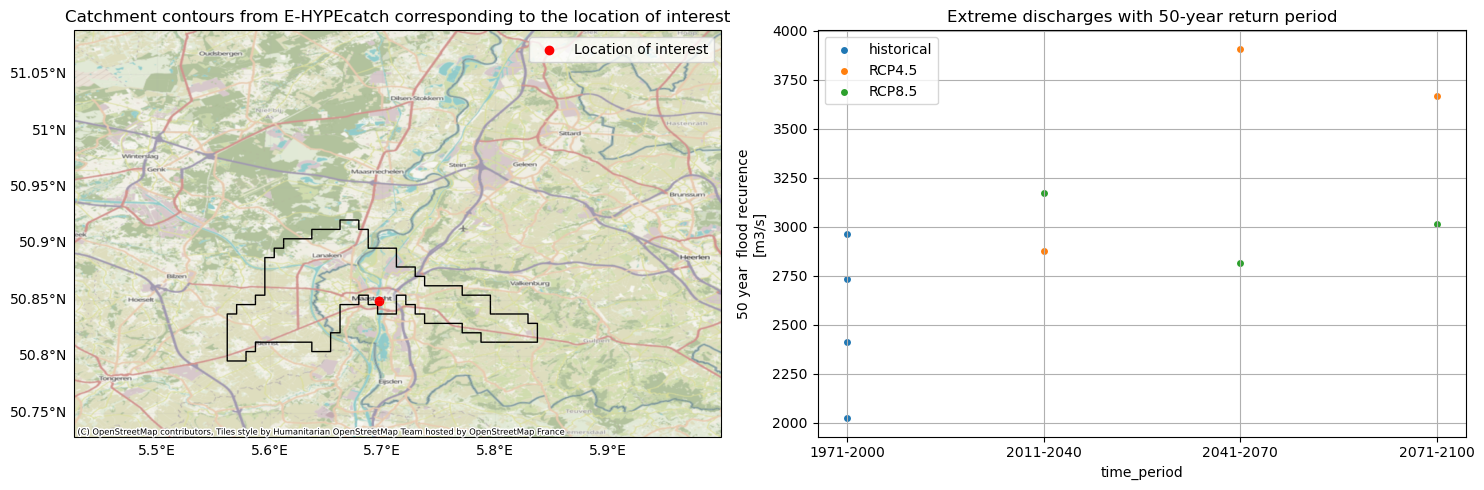

In [170]:
fig = plt.figure(figsize=(15, 5))
ax0 = plt.subplot2grid((1, 4), (0, 0), colspan=2, projection=ccrs.PlateCarree())
ax1 = plt.subplot2grid((1, 4), (0, 2), colspan=2)

# plot catchment contours on map
ax0.set_ylim([bbox[1], bbox[3]])
ax0.set_xlim([bbox[0], bbox[2]])
gl = ax0.gridlines(draw_labels=True, alpha=0.1)
gl.top_labels = gl.right_labels = False
catchment.geometry.plot(ax=ax0, facecolor='None')
ax0.scatter(loc[0], loc[1], color='red', label='Location of interest')
ax0.legend()
ctx.add_basemap(ax=ax0,crs='EPSG:4326', attribution_size=6)
ax0.set_title('Catchment contours from E-HYPEcatch corresponding to the location of interest')

# Plot flood occurence data
ds_flood_sel['rdisreturnmax50_tmean'].sel(scenarios='historical').plot.scatter(ax=ax1, x='time_period', label='historical')
ds_flood_sel['rdisreturnmax50_tmean'].sel(scenarios='rcp45').plot.scatter(ax=ax1, x='time_period', label='RCP4.5')
ds_flood_sel['rdisreturnmax50_tmean'].sel(scenarios='rcp85').plot.scatter(ax=ax1, x='time_period', label='RCP8.5')
ax1.grid()
ax1.legend()
ax1.set_title('Extreme discharges with 50-year return period')
plt.tight_layout()

The above comparison can also be plotted in terms of relative change in extreme discharges:

In [192]:
def preprocess_add_gcm_scenarios_relative(ds):
    filename = ds.encoding['source'].split("/")[-1].split("\\")[-1]
    ds['gcm_rcm'] = f'{filename.split("_")[4]}_{filename.split("_")[7]}'
    ds = ds.set_coords('gcm_rcm').expand_dims('gcm_rcm')

    ds['scenarios'] = filename.split("_")[5]
    ds = ds.set_coords('scenarios').expand_dims('scenarios')

    time_period = [filename.split("_")[8]]
    ds = ds.assign_coords(time_period=("time",time_period))
    return ds

In [193]:
files = glob(os.path.join(data_folder_catch, 'rdisreturnmax50_tmean_rel_E-HYPEcatch*_catch_v1.nc'))
ds_flood_rel = xr.open_mfdataset(files, preprocess=preprocess_add_gcm_scenarios_relative)

# Subset to catchment of interest
ds_flood_rel_sel = ds_flood_rel.sel(id=catch_id)

In [194]:
ds_flood_rel_sel

<xarray.Dataset> Size: 764B
Dimensions:                (scenarios: 2, gcm_rcm: 4, time: 3)
Coordinates:
    id                     int32 4B 9503381
  * time                   (time) datetime64[ns] 24B 2011-01-01 ... 2071-01-01
  * gcm_rcm                (gcm_rcm) <U36 576B 'MOHC-HadGEM2-ES_KNMI-RACMO22E...
  * scenarios              (scenarios) <U5 40B 'rcp45' 'rcp85'
    time_period            (time) object 24B '2011-2040' '2041-2070' '2071-2100'
Data variables:
    rdisreturnmax50_tmean  (scenarios, gcm_rcm, time) float32 96B dask.array<chunksize=(1, 1, 1), meta=np.ndarray>
Attributes: (12/30)
    CDI:                      Climate Data Interface version 1.8.2 (http://mp...
    Conventions:              CF-1.6
    NCO:                      netCDF Operators version 4.7.7 (Homepage = http...
    frequency:                year
    comment:                  -
    CDO:                      Climate Data Operators version 1.8.2 (http://mp...
    ...                       ...
    invar_experiment_name:    rcp45
    time_coverage_start:      20110101
    time_coverage_end:        20401231
    reference_period:         1971-2000
    variable_name:            rdisreturnmax50_tmean
    contact:                  copernicus-support@ecmwf.int

c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{F1855C36-0FD3-4197-A97E-4AB8346F3786}\SVROOT\Users\aleksand\AppData\Local\miniforge3\envs\climaax_floods\Lib\site-packages\matplotlib\colors.py:1318: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
c:\SnapVolumesTemp\MountPoints\{45c63495-0000-0000-0000-100000000000}\{F1855C36-0FD3-4197-A97E-4AB8346F3786}\SVROOT\Users\aleksand\AppData\Local\miniforge3\envs\climaax_floods\Lib\site-packages\matplotlib\colors.py:1325: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)


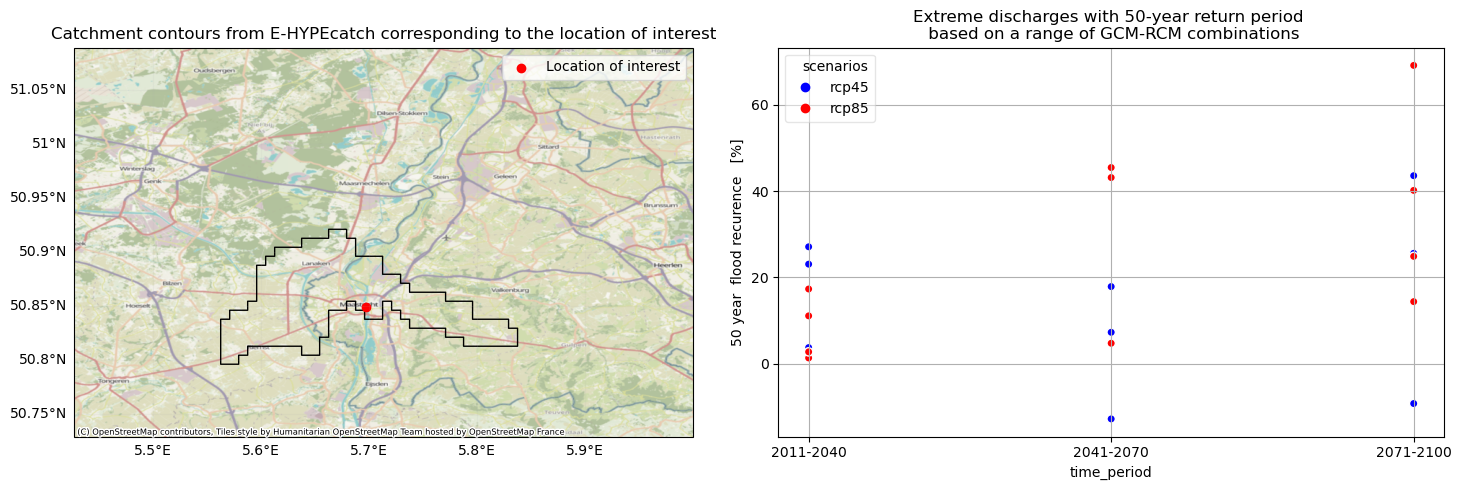

In [195]:
fig = plt.figure(figsize=(15, 5))
ax0 = plt.subplot2grid((1, 4), (0, 0), colspan=2, projection=ccrs.PlateCarree())
ax1 = plt.subplot2grid((1, 4), (0, 2), colspan=2)

# plot catchment contours on map
ax0.set_ylim([bbox[1], bbox[3]])
ax0.set_xlim([bbox[0], bbox[2]])
gl = ax0.gridlines(draw_labels=True, alpha=0.1)
gl.top_labels = gl.right_labels = False
catchment.geometry.plot(ax=ax0, facecolor='None')
ax0.scatter(loc[0], loc[1], color='red', label='Location of interest')
ax0.legend()
ctx.add_basemap(ax=ax0,crs='EPSG:4326', attribution_size=6)
ax0.set_title('Catchment contours from E-HYPEcatch corresponding to the location of interest')

# Plot flood occurence data
ds_flood_rel_sel['rdisreturnmax50_tmean'].plot.scatter(x='time_period', hue='scenarios', add_legend=True, add_colorbar=False, cmap='bwr')
ax1.grid()
ax1.set_title('Extreme discharges with 50-year return period \n based on a range of GCM-RCM combinations')
plt.tight_layout()

There can be a significant spread in estimated increase in extreme discharges across GCM-RCM combinations (climate models). We can check the average estimates and their range based on the data above:

In [225]:
for scen in ['rcp45', 'rcp85']:
       for time_period in ['2011-2040', '2041-2070', '2071-2100']:
              msg = f'Scenario {scen.upper()}, time period {time_period}: increase in 50-year extreme discharge is ' + \
                     f'{ds_flood_rel_sel['rdisreturnmax50_tmean'].sel(scenarios=scen).where(ds_flood_rel_sel['time_period']==time_period, drop=True).mean(dim='gcm_rcm').values[0]:.1f}%' + \
                     f' ({ds_flood_rel_sel['rdisreturnmax50_tmean'].sel(scenarios=scen).where(ds_flood_rel_sel['time_period']==time_period, drop=True).min(dim='gcm_rcm').values[0]:.1f}% to ' + \
                     f'{ds_flood_rel_sel['rdisreturnmax50_tmean'].sel(scenarios=scen).where(ds_flood_rel_sel['time_period']==time_period, drop=True).max(dim='gcm_rcm').values[0]:.1f}%)'
              print(msg)
              print()

Scenario RCP45, time period 2011-2040: increase in 50-year extreme discharge is 18.0% (3.7% to 27.1%)

Scenario RCP45, time period 2041-2070: increase in 50-year extreme discharge is 4.9% (-12.8% to 17.9%)

Scenario RCP45, time period 2071-2100: increase in 50-year extreme discharge is 20.0% (-9.2% to 43.6%)

Scenario RCP85, time period 2011-2040: increase in 50-year extreme discharge is 8.1% (1.3% to 17.3%)

Scenario RCP85, time period 2041-2070: increase in 50-year extreme discharge is 31.1% (4.7% to 45.4%)

Scenario RCP85, time period 2071-2100: increase in 50-year extreme discharge is 37.1% (14.4% to 69.1%)



Author of the workflow:  
Natalia Aleksandrova (Deltares)